In [1]:

!pip install uproot awkward 
from uproot_io import Events, View
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import os

file_path = "/home/jovyan/CheatedRecoFile_5.root"

# Check if the file exists
if os.path.exists(file_path):
    print(f"File exists: {file_path}")
    print(f"File size: {os.path.getsize(file_path)} bytes")
else:
    print(f"File does not exist: {file_path}")

events_unseen = Events("CheatedRecoFile_5.root")


from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

File exists: /home/jovyan/CheatedRecoFile_5.root
File size: 583465641 bytes


In [2]:
# from before 
def correlation(events, event_idx):
    x_hits = events.reco_hits_x_w[event_idx]
    w_hits = events.reco_hits_w[event_idx] 

    # Check if there are valid hits
    if len(w_hits) == len(x_hits) and len(w_hits) > 15: # talk about advantages and disadvantages of results with a threshold 
        if np.std(x_hits) == 0 or np.std(w_hits) == 0:
            return None  # No valid correlation if there's no variation in data
        
        correlation = np.corrcoef(x_hits, w_hits)[0, 1]
        
        # Fit line using w_hits for x and calculate predicted y-values
        line_fit = np.polyfit(w_hits, x_hits, 1)
        line_y_pred = np.polyval(line_fit, w_hits)
        
        # Calculate line error between predicted and actual x_hits
        line_error = np.mean((x_hits - line_y_pred) ** 2)
        
        # Normalize scores
        correlation_score = abs(correlation) if not np.isnan(correlation) else 0
        error_score = max(0, 1 - line_error / 20) if line_error < 20 else 0
        
        # Weighted score
        line_score = (correlation_score * 0.7) + (error_score * 0.3)
        
        return (line_score * 100)  # Return the score and category

    else:
        return None

# from before 

def noise(events, event_idx, eps=2, min_samples=5):
    # Extract hit positions (no PDG filtering, just use reco hits)
    x_hits = events.reco_hits_x_w[event_idx]
    w_hits = events.reco_hits_w[event_idx]

    # Check if there are valid hits
    if len(w_hits) == len(x_hits) and len(w_hits) > 15:
        # Combine the coordinates for clustering
        hits_coordinates = np.column_stack((w_hits, x_hits))

        # Apply DBSCAN clustering
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(hits_coordinates)
        labels = db.labels_

        # Count noise points (labeled as -1)
        n_noise = np.sum(labels == -1)

        # Count clusters (unique labels excluding -1)
        unique_clusters = set(labels) - {-1}
        n_clusters = len(unique_clusters)

        return n_noise + n_clusters
    else:
        return None
def rms(events, event_idx):
    w_hits = events.reco_hits_w[event_idx]
    x_hits = events.reco_hits_x_w[event_idx]

    if len(w_hits) == len(x_hits) and len(w_hits) > 15:
        slope, intercept = np.polyfit(w_hits, x_hits, 1)
        
        actual = x_hits
        predicted = slope * w_hits + intercept
        
        meanSquaredError = ((predicted - actual) ** 2).mean()
        return np.sqrt(meanSquaredError)
    else: 
        return None 


import numpy as np

def angle(events, event_idx):
    x_hits = events.reco_hits_x_w[event_idx]
    w_hits = events.reco_hits_w[event_idx]

    if len(w_hits) == len(x_hits) and len(w_hits) > 15:
        # Fit the best-fit line
        line_fit = np.polyfit(w_hits, x_hits, 1)
        line_slope = line_fit[0]
        line_intercept = line_fit[1]

        # Calculate residuals (distance from the line)
        line_y_pred = np.polyval(line_fit, w_hits)
        residuals = np.abs(x_hits - line_y_pred)

        # Find the index of the furthest point
        furthest_idx = np.argmax(residuals)
        furthest_point = np.array([x_hits[furthest_idx], w_hits[furthest_idx]])

        # Start of the line is at the minimum W-coordinate
        min_w = np.min(w_hits)
        start_point = np.array([line_slope * min_w + line_intercept, min_w])

        # End of the red line (best-fit line) at the maximum W-coordinate
        max_w = np.max(w_hits)
        end_of_red_line = np.array([line_slope * max_w + line_intercept, max_w])

        # Calculate the lengths of the three sides of the triangle
        red_line_length = np.linalg.norm(end_of_red_line - start_point)  # Distance between start and end of red line
        purple_line_length = np.linalg.norm(furthest_point - start_point)  # Distance between start and furthest point (purple line)
        third_line_length = np.linalg.norm(furthest_point - end_of_red_line)  # Distance between end of red line and furthest point (third line)

        # Using the cosine rule to calculate the angle between the red and purple lines
        cos_theta = (red_line_length**2 + purple_line_length**2 - third_line_length**2) / (2 * red_line_length * purple_line_length)
        angle_radians = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip value to avoid out-of-bound errors
        angle_degrees = np.degrees(angle_radians)  # Convert radians to degrees
        
        return angle_degrees
    else:
        return None





def line(events, event_idx):
    w_hits = np.array(events.reco_hits_w[event_idx])
    x_hits = np.array(events.reco_hits_x_w[event_idx])

    if len(w_hits) == len(x_hits) and len(w_hits) > 15:
    
        # Calculate differences between consecutive points
        dx = np.diff(w_hits)
        dy = np.diff(x_hits)
    
        # Compute segment lengths
        segment_lengths = np.sqrt(dx**2 + dy**2)
    
        # Total arc length (line integral)
        total_length = np.sum(segment_lengths)
    
        # Normalize by the number of points
        normalised_length = total_length / len(w_hits)

        return normalised_length
    else:
        return None 



def q4(events, event_idx):
    adcs = events.reco_adcs_w[event_idx]

    if len(adcs) > 15:

        q4_idx = len(adcs) // 4

        adcs_q4 = adcs[-q4_idx:]
    
        ratio = sum(adcs_q4) / sum(adcs)
    
    
        return ratio
    else:
       return None

In [3]:
def categorise_event(events, event_idx, shower_pdg_set):
    # Extract PDG code
    pdg_code = events.mc_pdg[event_idx]  # Assuming this holds a single PDG code
    
    # Determine if event is a shower or track
    if pdg_code in shower_pdg_set:
        return 'shower'
    else:
        return 'track'  # All other PDG codes are considered as track

In [4]:
# Get feature data

training_events = Events("CheatedRecoFile_0.root") # Train events with same data as Likelihood to ensure fairness

''' Code for identifying candidate lepton in event. '''

def identify_candidate(events):
    identifiers = events.event_number
    data = np.arange(0, len(events.event_number))
    slices = []
    start_idx = 0

    # Split data into slices based on changes in identifiers
    for i in range(1, len(identifiers)):
        if identifiers[i] != identifiers[i - 1]:
            slices.append(data[start_idx:i])
            start_idx = i  # Update start index for the next slice

    slices.append(data[start_idx:])

    results = []

    for event_number, event_indices in enumerate(slices):  # Enumerate slices to get the event number

        w_hits_event = []
        indices = []  # To keep track of the corresponding `i` values
        
        for i in event_indices:
            w_hits_event.append(events.reco_hits_w[i])
            indices.append(i)  # Store the corresponding `i` values
        
        # Find the index of the maximum length in w_hits_event
        max_idx = max(range(len(w_hits_event)), key=lambda idx: len(w_hits_event[idx]))
        
        # Retrieve the corresponding `i` value
        candidate_idx = indices[max_idx]

        results.append((event_number, candidate_idx))
    
    return results

array = identify_candidate(training_events)
cheated_0_candidates = [idx[1] for idx in array]

def prepare_training_data(events, shower_pdg_set):
    """Prepares the feature matrix and labels for training."""
    features = []
    labels = []

    for event_idx in cheated_0_candidates:
        # Calculate feature scores
        correlation_score = correlation(events, event_idx)
        noise_score = noise(events, event_idx)
        rms_score = rms(events, event_idx)
        angle_score = angle(events, event_idx)
        line_score = line(events, event_idx)
        q4_score = q4(events, event_idx)

        # Ensure valid scores
        if None in [correlation_score, noise_score, rms_score, angle_score, line_score, q4_score]:
            continue

        # Append feature vector
        features.append([correlation_score, noise_score, rms_score, angle_score, line_score, q4_score])

        # Append label (1 for shower, 0 for track)
        labels.append(1 if categorise_event(events, event_idx, shower_pdg_set) == 'shower' else 0)

    return np.array(features), np.array(labels) # Return as arrays


shower_pdg_set = {11, -11, 22, -22}  # Define PDG codes for showers

In [5]:
x_train, y_train = prepare_training_data(training_events, shower_pdg_set) # Training data
x_test, y_test = prepare_training_data(events_unseen, shower_pdg_set) # Testing data - with same data as Likelihood

Training Accuracy: 98.52%
Test Accuracy: 96.32%
Confusion Matrix:
[[521  12]
 [ 22 368]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       533
           1       0.97      0.94      0.96       390

    accuracy                           0.96       923
   macro avg       0.96      0.96      0.96       923
weighted avg       0.96      0.96      0.96       923



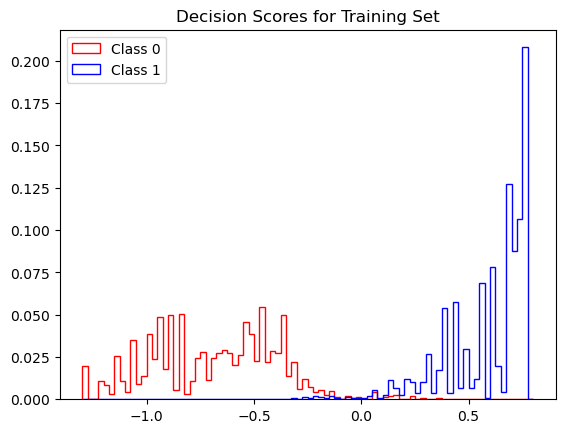

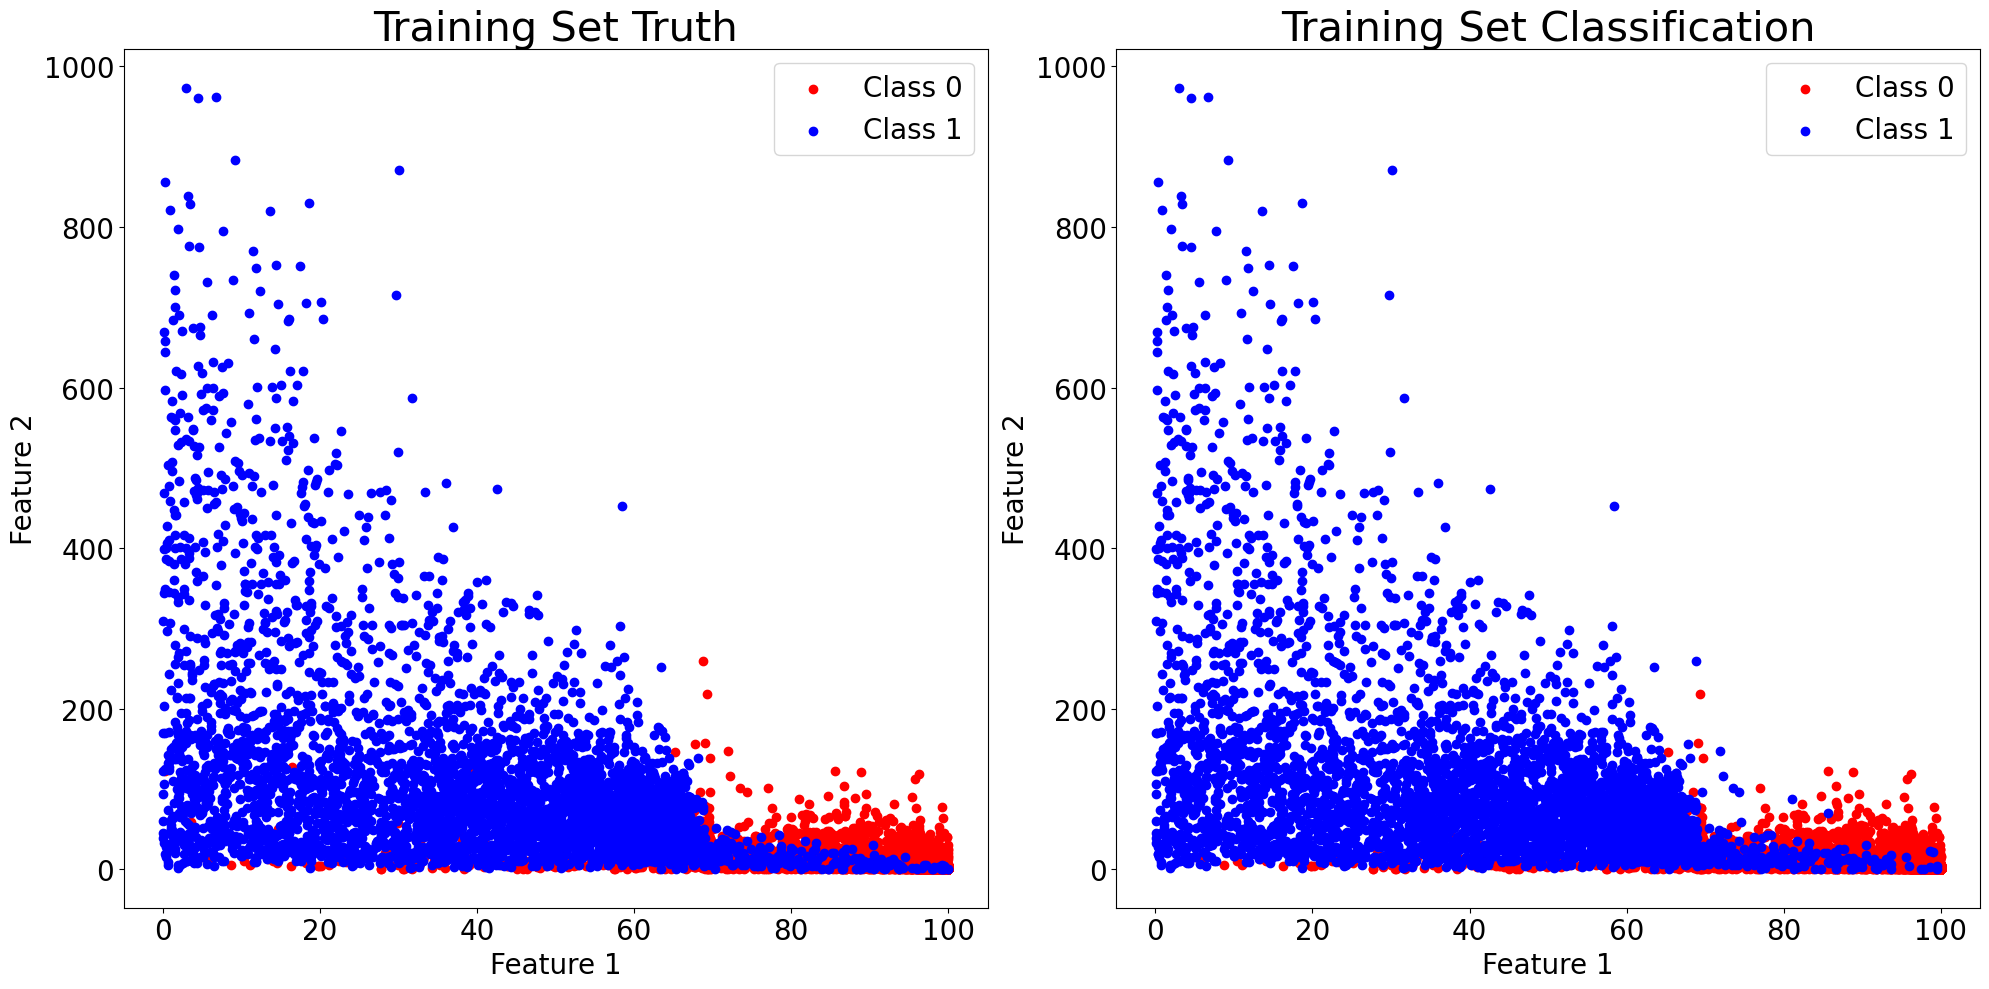

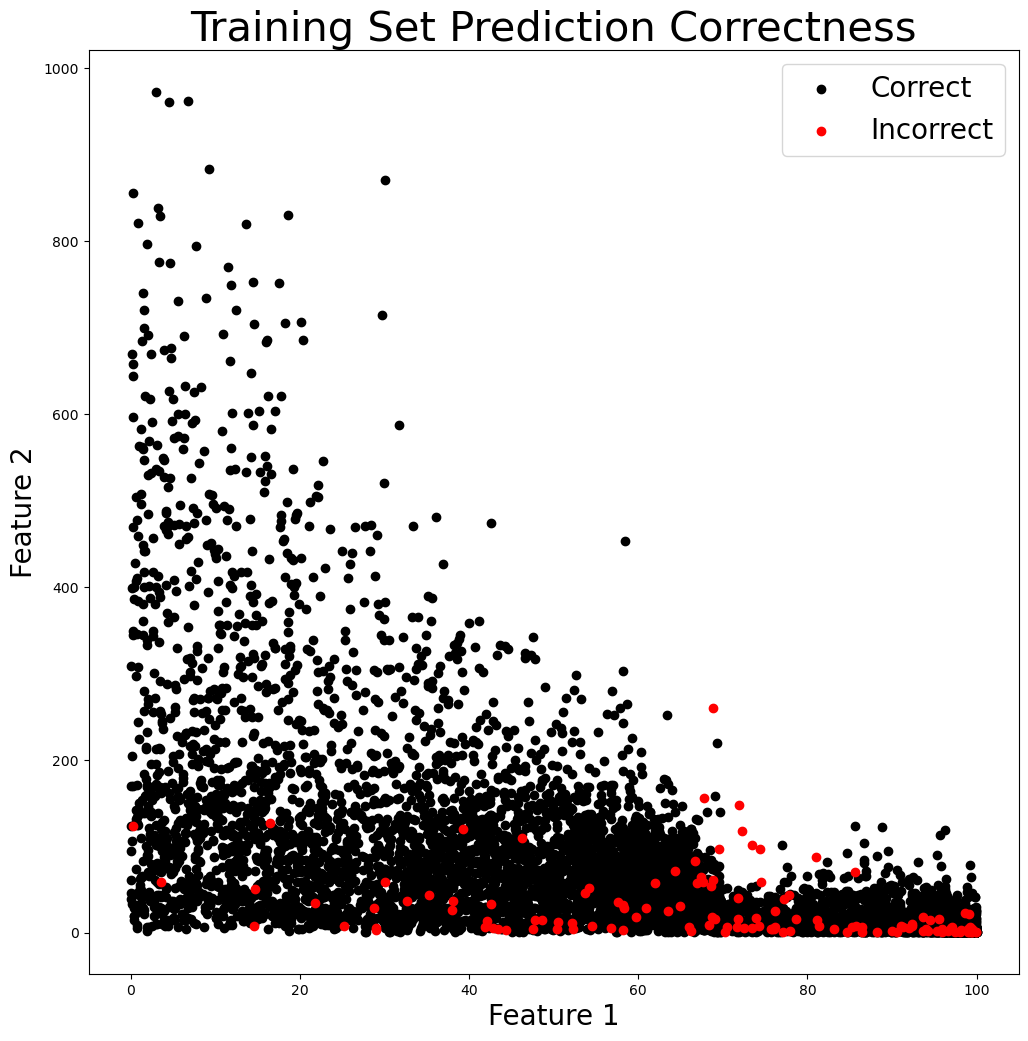

In [6]:
''' Using AdaBoostClassifier'''
bdt = AdaBoostClassifier(n_estimators=100, random_state=0, algorithm='SAMME')
bdt.fit(x_train, y_train) # Do a BDT model on Training

# Evaluate performance on the training set
train_accuracy = bdt.score(x_train, y_train)
print(f"Training Accuracy: {train_accuracy:.2%}")

# Evaluate performance on the test set
y_pred = bdt.predict(x_test) 
test_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Test Accuracy: {test_accuracy:.2%}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)

# Plot decision scores for the training set
train_scores = bdt.decision_function(x_train)
min_f = np.round(np.min(train_scores), 1)
max_f = np.round(np.max(train_scores), 1)
bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)

cls_0_scores = train_scores[np.where(y_train == 0)]
cls_1_scores = train_scores[np.where(y_train == 1)]

weights_0 = np.ones_like(cls_0_scores) / len(cls_0_scores)
weights_1 = np.ones_like(cls_1_scores) / len(cls_1_scores)

plt.hist(cls_0_scores, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0')
plt.hist(cls_1_scores, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1')
plt.legend()
plt.title("Decision Scores for Training Set")
plt.show()

# Visualise classification on the training set
titlesize = 30
labelsize = 20
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Ground truth
ax = axes[0]
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
cls_0 = np.where(y_train == 0)
ax.scatter(x_train[cls_0, 0], x_train[cls_0, 1], c="r", label="Class 0")
cls_1 = np.where(y_train == 1)
ax.scatter(x_train[cls_1, 0], x_train[cls_1, 1], c="b", label="Class 1")
ax.set_xlabel("Feature 1", fontsize=labelsize)
ax.set_ylabel("Feature 2", fontsize=labelsize)
ax.set_title("Training Set Truth", fontsize=titlesize)
ax.legend(fontsize=labelsize)

# Predictions
ax = axes[1]
pred = bdt.predict(x_train)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
cls_0 = np.where(pred == 0)
ax.scatter(x_train[cls_0, 0], x_train[cls_0, 1], c="r", label="Class 0")
cls_1 = np.where(pred == 1)
ax.scatter(x_train[cls_1, 0], x_train[cls_1, 1], c="b", label="Class 1")
ax.set_xlabel("Feature 1", fontsize=labelsize)
ax.set_ylabel("Feature 2", fontsize=labelsize)
ax.set_title("Training Set Classification", fontsize=titlesize)
ax.legend(fontsize=labelsize)

fig.tight_layout()
plt.show()

# Visualise prediction correctness
plt.figure(figsize=(12, 12))
correct = np.where(pred == y_train)
plt.scatter(x_train[correct, 0], x_train[correct, 1], c="k", label="Correct")
incorrect = np.where(pred != y_train)
plt.scatter(x_train[incorrect, 0], x_train[incorrect, 1], c="r", label="Incorrect")
plt.xlabel("Feature 1", fontsize=labelsize)
plt.ylabel("Feature 2", fontsize=labelsize)
plt.title("Training Set Prediction Correctness", fontsize=titlesize)
plt.legend(fontsize=labelsize)
plt.show()

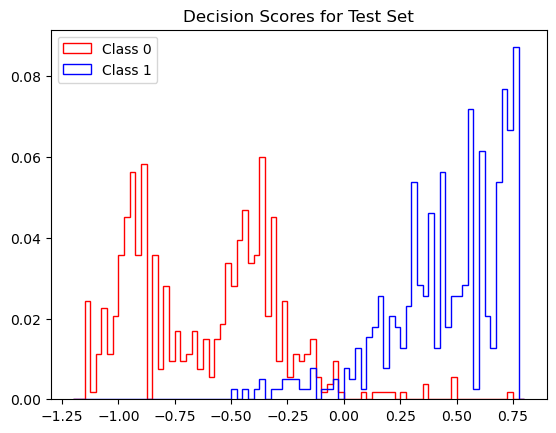

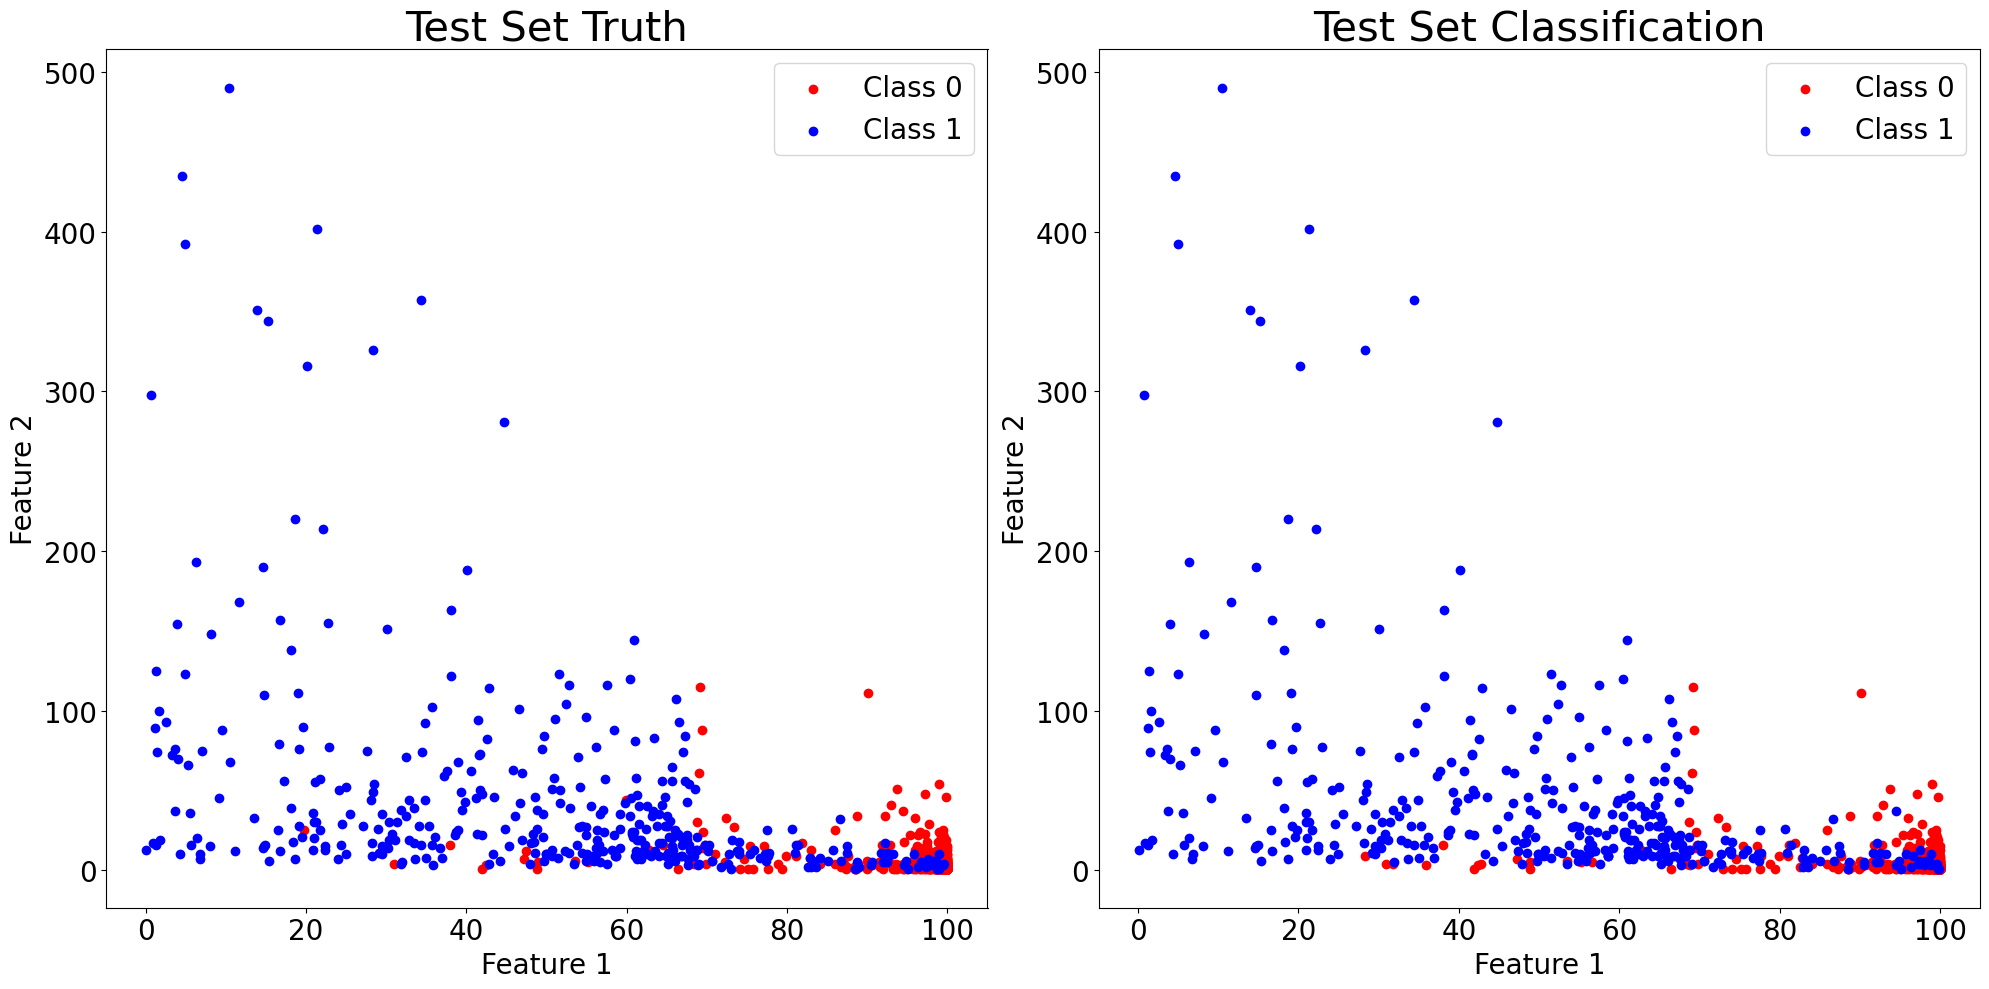

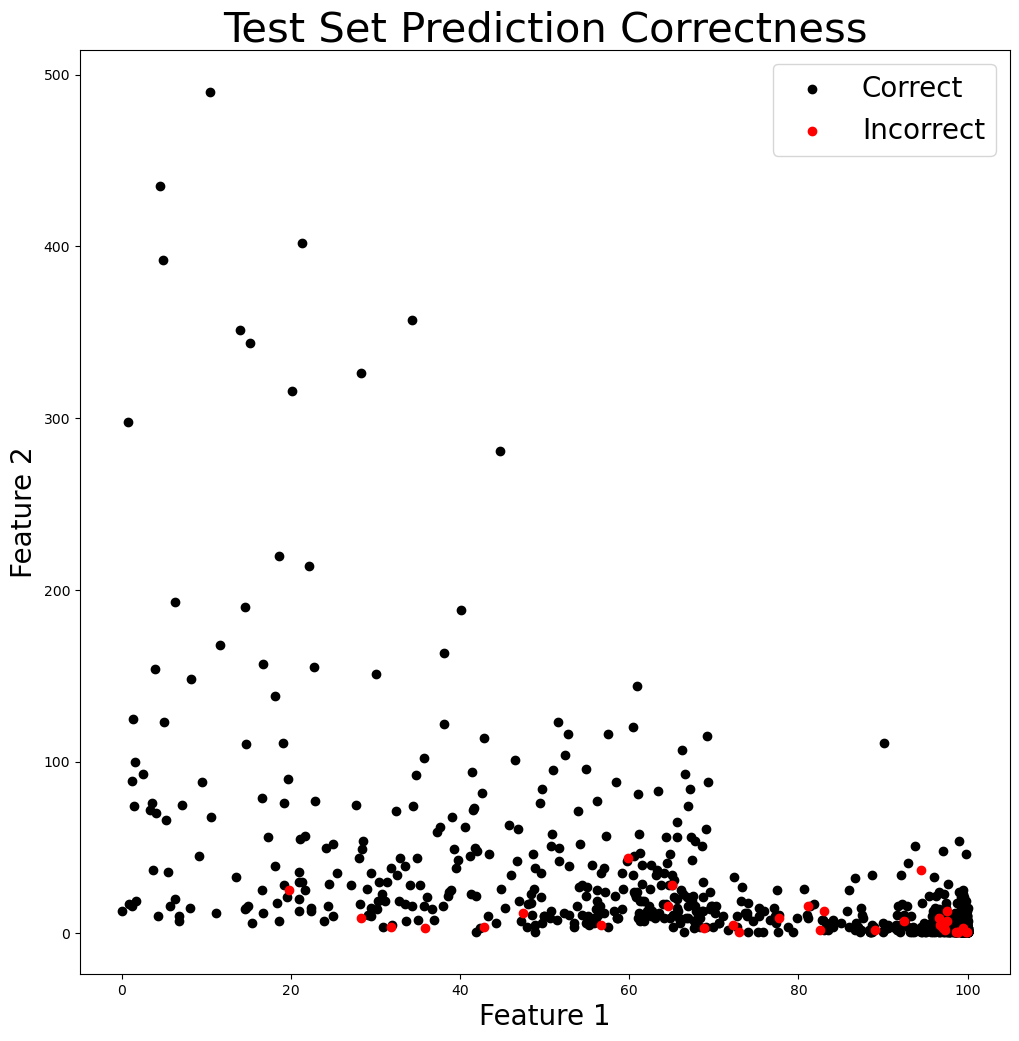

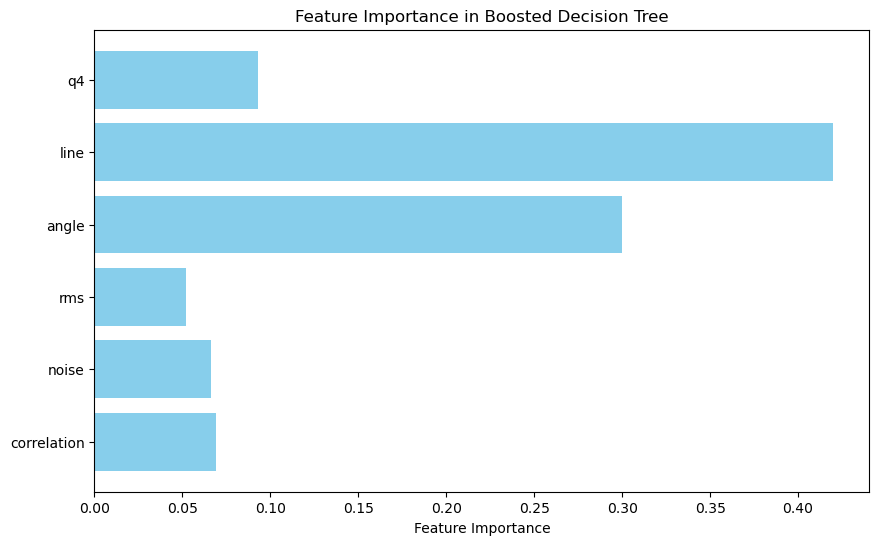

In [7]:
# Same for testing Scores
test_scores = bdt.decision_function(x_test)
min_f = np.round(np.min(test_scores), 1)
max_f = np.round(np.max(test_scores), 1)
bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)

cls_0_scores = test_scores[np.where(y_test == 0)]
cls_1_scores = test_scores[np.where(y_test == 1)]

weights_0 = np.ones_like(cls_0_scores) / len(cls_0_scores)
weights_1 = np.ones_like(cls_1_scores) / len(cls_1_scores)

plt.hist(cls_0_scores, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0')
plt.hist(cls_1_scores, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1')
plt.legend()
plt.title("Decision Scores for Test Set")
plt.show()

# Visualize classification on the test set
titlesize = 30
labelsize = 20
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Ground truth
ax = axes[0]
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
cls_0 = np.where(y_test == 0)
ax.scatter(x_test[cls_0, 0], x_test[cls_0, 1], c="r", label="Class 0")
cls_1 = np.where(y_test == 1)
ax.scatter(x_test[cls_1, 0], x_test[cls_1, 1], c="b", label="Class 1")
ax.set_xlabel("Feature 1", fontsize=labelsize)
ax.set_ylabel("Feature 2", fontsize=labelsize)
ax.set_title("Test Set Truth", fontsize=titlesize)
ax.legend(fontsize=labelsize)

# Predictions
ax = axes[1]
pred = bdt.predict(x_test)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
cls_0 = np.where(pred == 0)
ax.scatter(x_test[cls_0, 0], x_test[cls_0, 1], c="r", label="Class 0")
cls_1 = np.where(pred == 1)
ax.scatter(x_test[cls_1, 0], x_test[cls_1, 1], c="b", label="Class 1")
ax.set_xlabel("Feature 1", fontsize=labelsize)
ax.set_ylabel("Feature 2", fontsize=labelsize)
ax.set_title("Test Set Classification", fontsize=titlesize)
ax.legend(fontsize=labelsize)

fig.tight_layout()
plt.show()

# Visualise prediction correctness
plt.figure(figsize=(12, 12))
correct = np.where(pred == y_test)
plt.scatter(x_test[correct, 0], x_test[correct, 1], c="k", label="Correct")
incorrect = np.where(pred != y_test)
plt.scatter(x_test[incorrect, 0], x_test[incorrect, 1], c="r", label="Incorrect")
plt.xlabel("Feature 1", fontsize=labelsize)
plt.ylabel("Feature 2", fontsize=labelsize)
plt.title("Test Set Prediction Correctness", fontsize=titlesize)
plt.legend(fontsize=labelsize)
plt.show()

# Feature importance visualization
feature_names = ['correlation', 'noise', 'rms', 'angle', 'line', 'q4']
plt.figure(figsize=(10, 6))
plt.barh(feature_names, bdt.feature_importances_, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Boosted Decision Tree')
plt.show()


Training Accuracy Grad: 99.39%
Test Accuracy Grad: 96.42%
Confusion Matrix Grad:
[[523  10]
 [ 23 367]]
Classification Report Grad:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       533
           1       0.97      0.94      0.96       390

    accuracy                           0.96       923
   macro avg       0.97      0.96      0.96       923
weighted avg       0.96      0.96      0.96       923



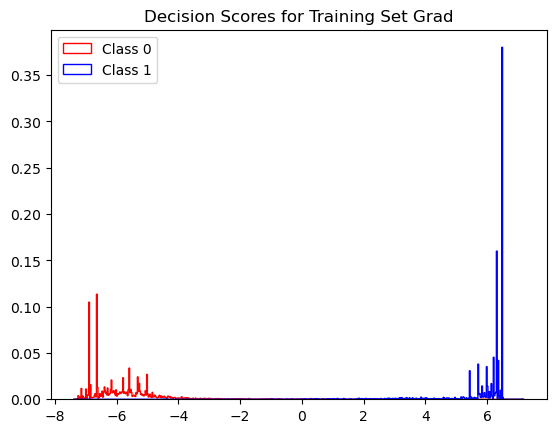

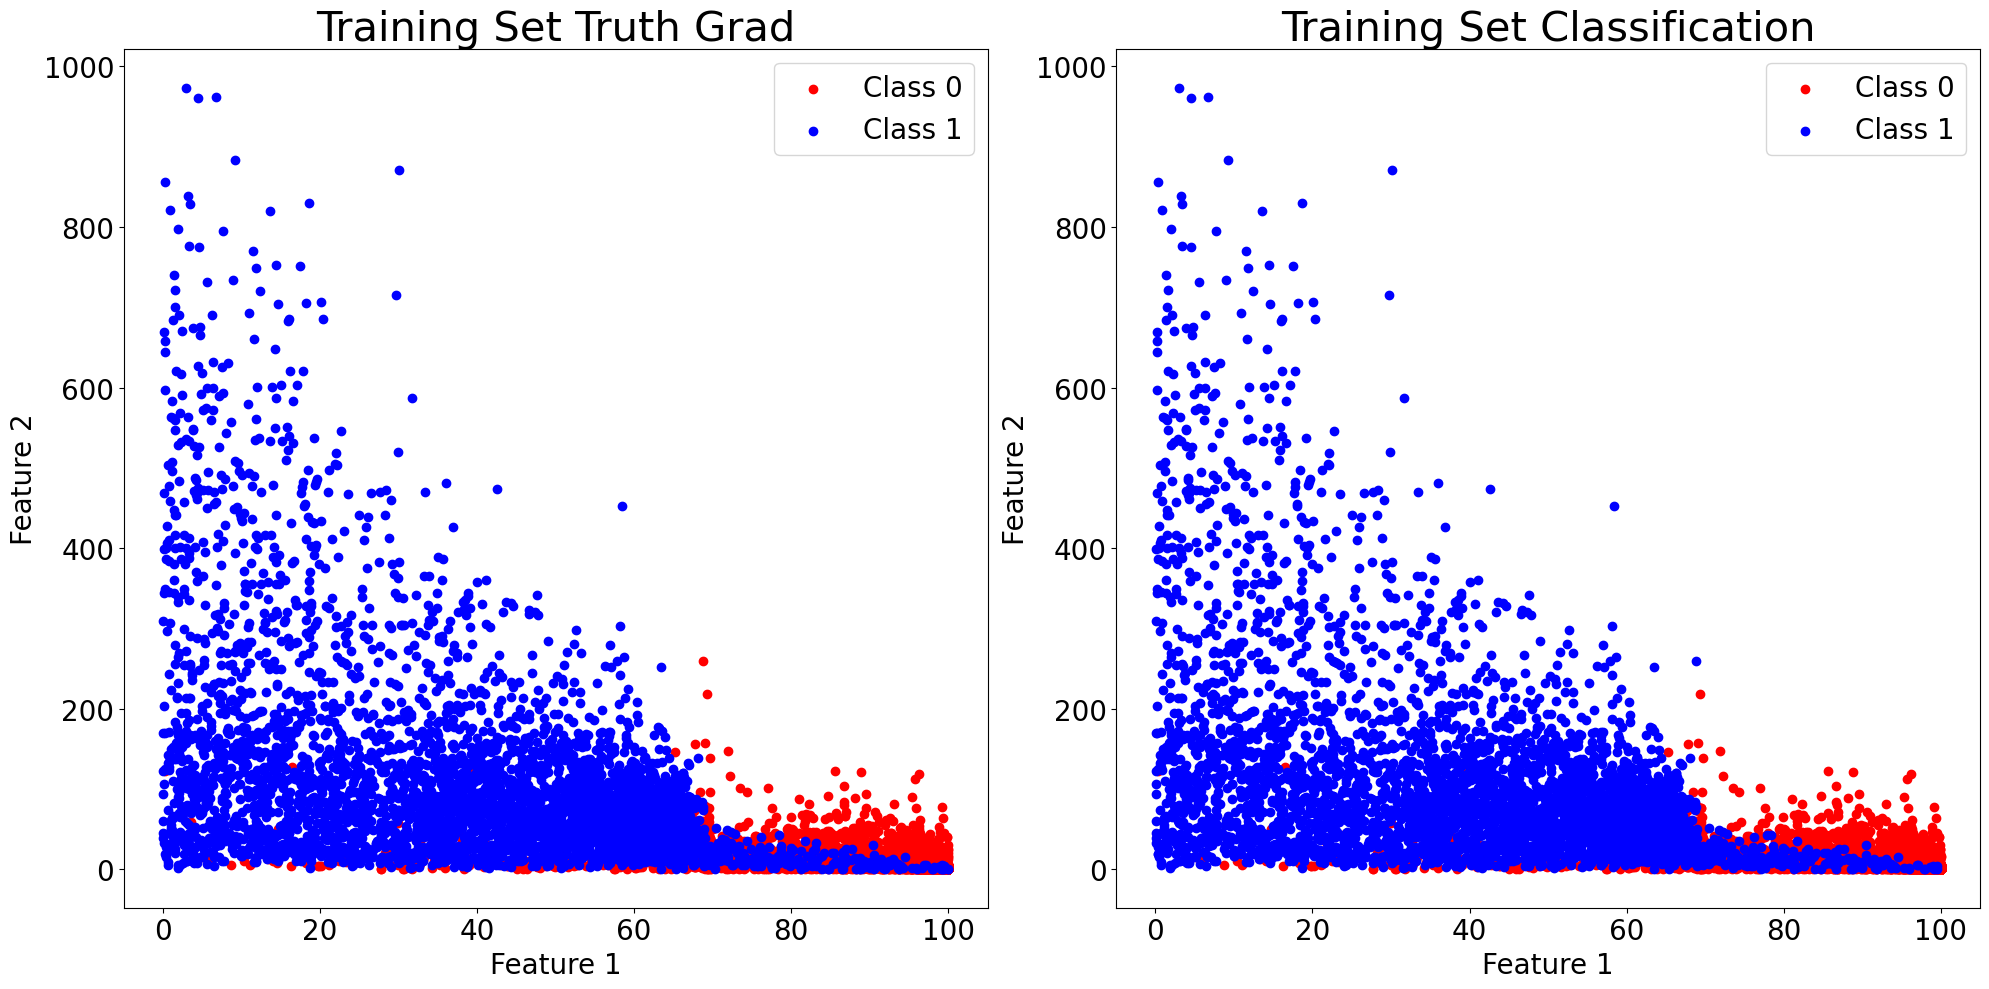

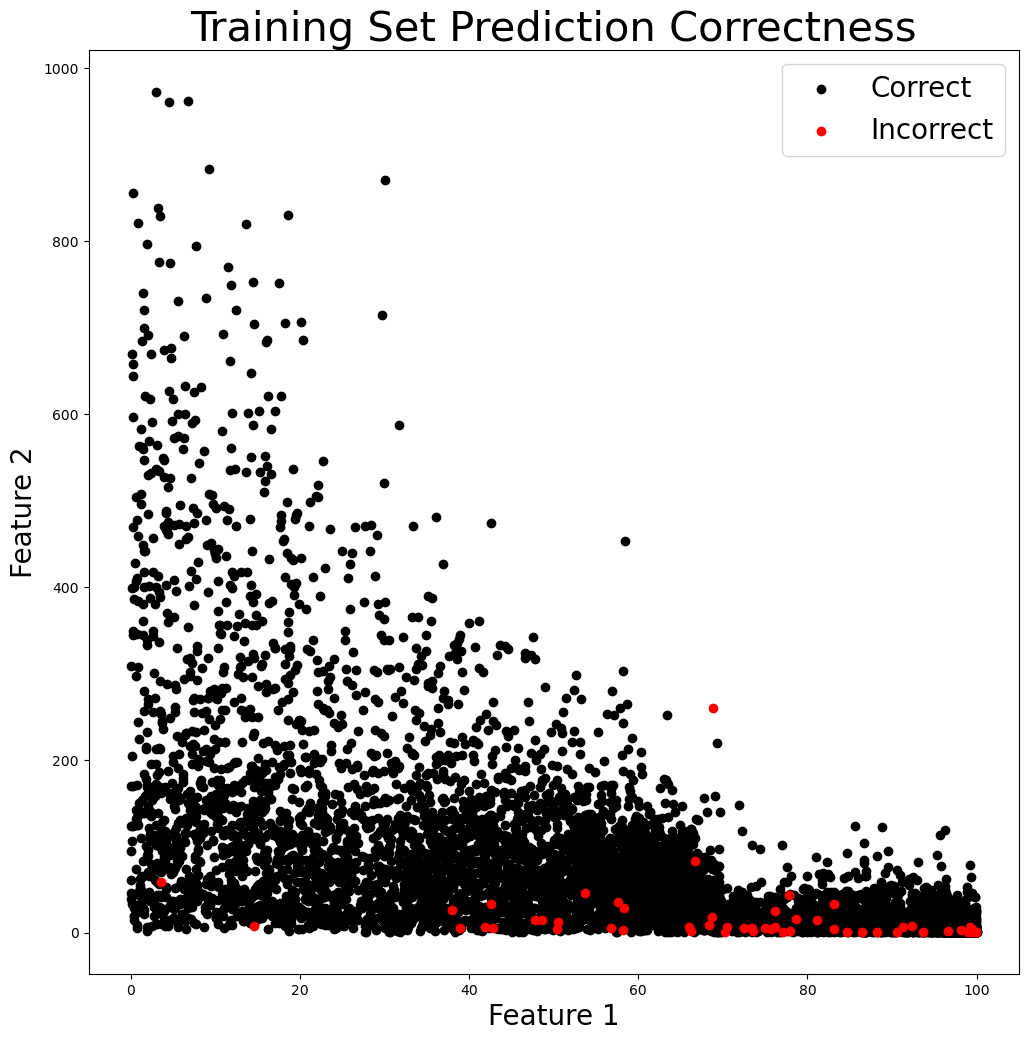

In [8]:
''' Using GradientBoostingClassifier '''


bdt2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
bdt2.fit(x_train, y_train) # Do a BDT model on Training

# Evaluate performance on the training set
train_accuracy = bdt2.score(x_train, y_train)
print(f"Training Accuracy Grad: {train_accuracy:.2%}")

# Evaluate performance on the test set
y_pred2 = bdt2.predict(x_test) 
test_accuracy = accuracy_score(y_test, y_pred2)
conf_matrix = confusion_matrix(y_test, y_pred2)
classification_rep = classification_report(y_test, y_pred2)

print(f"Test Accuracy Grad: {test_accuracy:.2%}")
print("Confusion Matrix Grad:")
print(conf_matrix)
print("Classification Report Grad:")
print(classification_rep)

# Plot decision scores for the training set
train_scores = bdt2.decision_function(x_train)
min_f = np.round(np.min(train_scores), 1)
max_f = np.round(np.max(train_scores), 1)
bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)

cls_0_scores = train_scores[np.where(y_train == 0)]
cls_1_scores = train_scores[np.where(y_train == 1)]

weights_0 = np.ones_like(cls_0_scores) / len(cls_0_scores)
weights_1 = np.ones_like(cls_1_scores) / len(cls_1_scores)

plt.hist(cls_0_scores, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0')
plt.hist(cls_1_scores, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1')
plt.legend()
plt.title("Decision Scores for Training Set Grad")
plt.show()

# Visualise classification on the training set
titlesize = 30
labelsize = 20
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Ground truth
ax = axes[0]
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
cls_0 = np.where(y_train == 0)
ax.scatter(x_train[cls_0, 0], x_train[cls_0, 1], c="r", label="Class 0")
cls_1 = np.where(y_train == 1)
ax.scatter(x_train[cls_1, 0], x_train[cls_1, 1], c="b", label="Class 1")
ax.set_xlabel("Feature 1", fontsize=labelsize)
ax.set_ylabel("Feature 2", fontsize=labelsize)
ax.set_title("Training Set Truth Grad", fontsize=titlesize)
ax.legend(fontsize=labelsize)

# Predictions
ax = axes[1]
pred = bdt2.predict(x_train)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
cls_0 = np.where(pred == 0)
ax.scatter(x_train[cls_0, 0], x_train[cls_0, 1], c="r", label="Class 0")
cls_1 = np.where(pred == 1)
ax.scatter(x_train[cls_1, 0], x_train[cls_1, 1], c="b", label="Class 1")
ax.set_xlabel("Feature 1", fontsize=labelsize)
ax.set_ylabel("Feature 2", fontsize=labelsize)
ax.set_title("Training Set Classification", fontsize=titlesize)
ax.legend(fontsize=labelsize)

fig.tight_layout()
plt.show()

# Visualise prediction correctness
plt.figure(figsize=(12, 12))
correct = np.where(pred == y_train)
plt.scatter(x_train[correct, 0], x_train[correct, 1], c="k", label="Correct")
incorrect = np.where(pred != y_train)
plt.scatter(x_train[incorrect, 0], x_train[incorrect, 1], c="r", label="Incorrect")
plt.xlabel("Feature 1", fontsize=labelsize)
plt.ylabel("Feature 2", fontsize=labelsize)
plt.title("Training Set Prediction Correctness", fontsize=titlesize)
plt.legend(fontsize=labelsize)
plt.show()

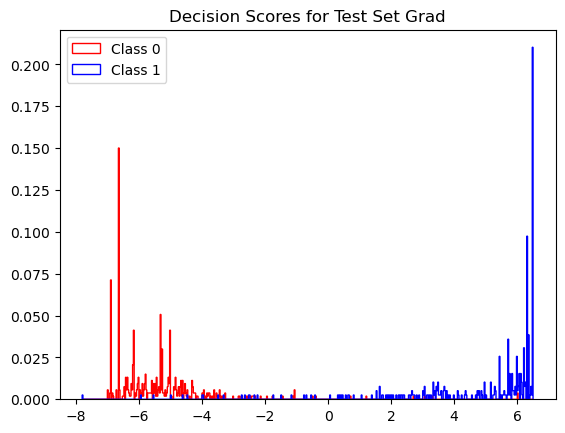

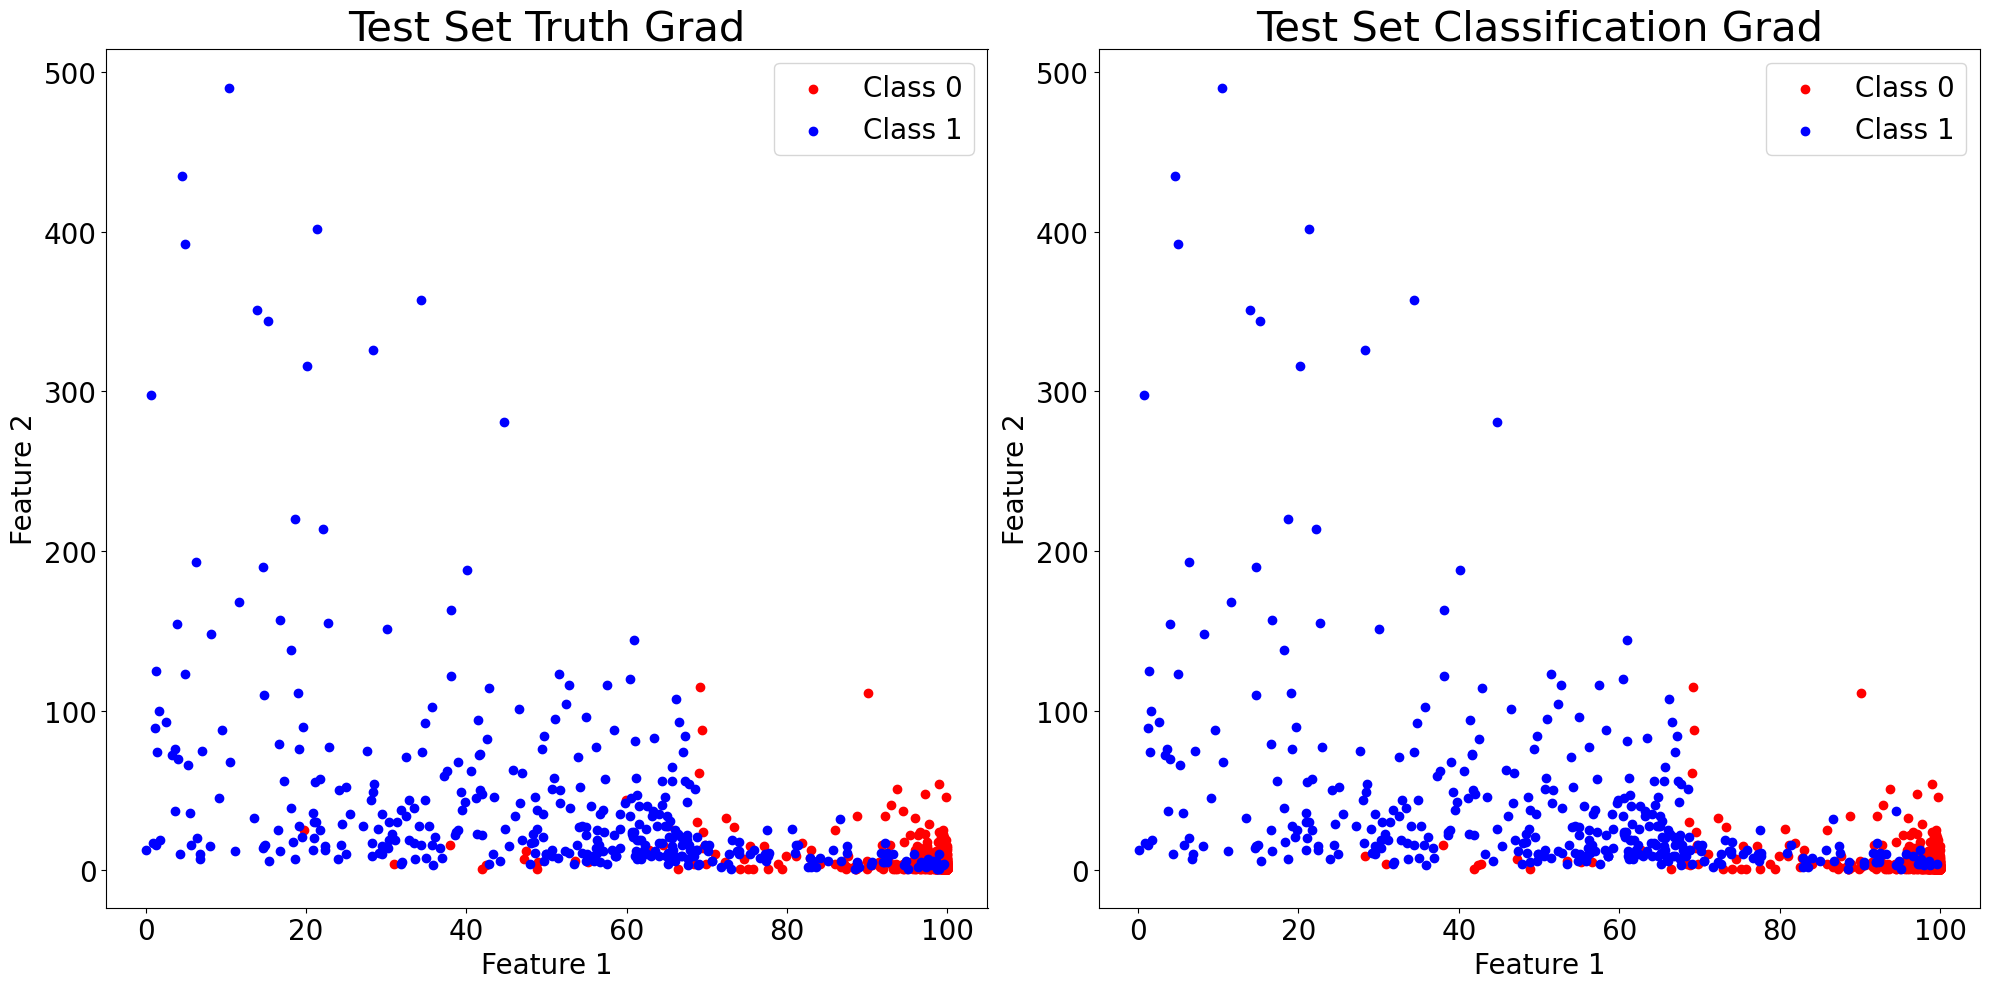

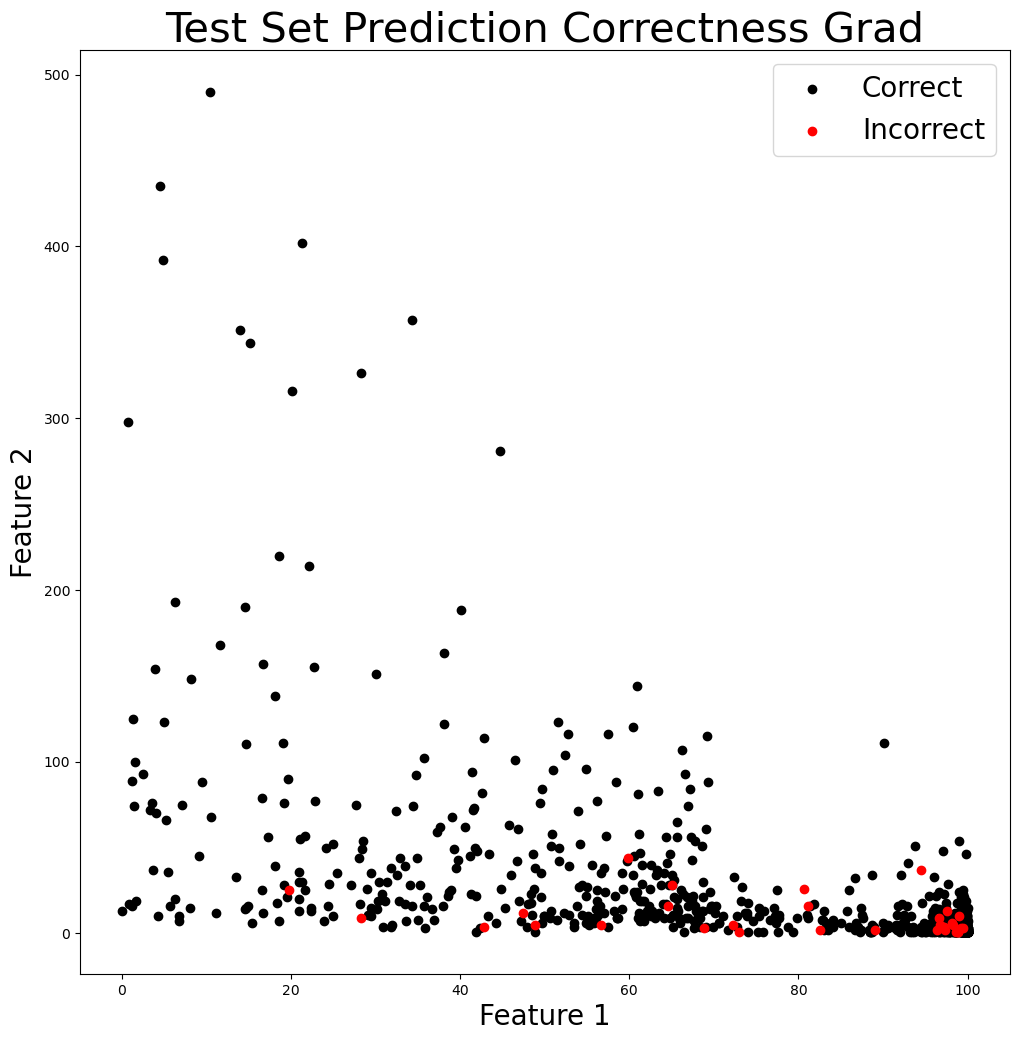

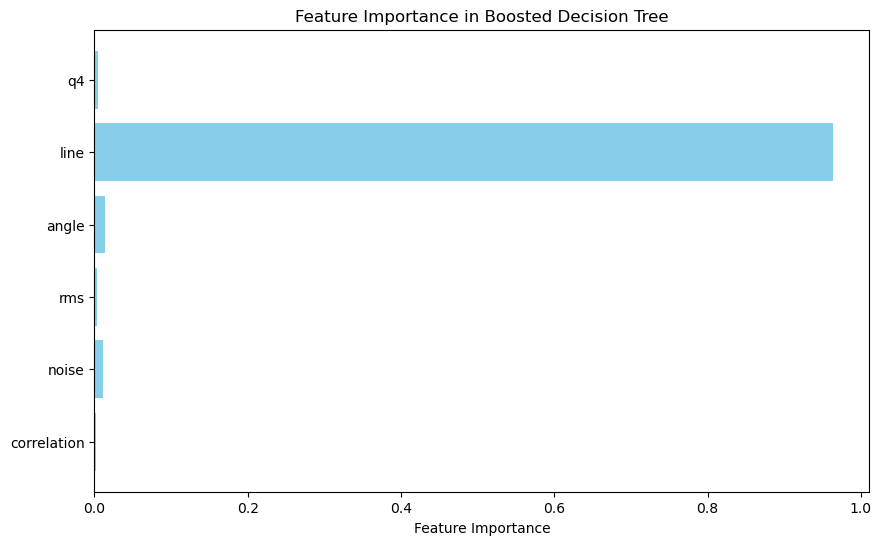

In [9]:
# Same for testing Scores
test_scores = bdt2.decision_function(x_test)
min_f = np.round(np.min(test_scores), 1)
max_f = np.round(np.max(test_scores), 1)
bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)

cls_0_scores = test_scores[np.where(y_test == 0)]
cls_1_scores = test_scores[np.where(y_test == 1)]

weights_0 = np.ones_like(cls_0_scores) / len(cls_0_scores)
weights_1 = np.ones_like(cls_1_scores) / len(cls_1_scores)

plt.hist(cls_0_scores, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0')
plt.hist(cls_1_scores, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1')
plt.legend()
plt.title("Decision Scores for Test Set Grad")
plt.show()

# Visualize classification on the test set
titlesize = 30
labelsize = 20
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Ground truth
ax = axes[0]
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
cls_0 = np.where(y_test == 0)
ax.scatter(x_test[cls_0, 0], x_test[cls_0, 1], c="r", label="Class 0")
cls_1 = np.where(y_test == 1)
ax.scatter(x_test[cls_1, 0], x_test[cls_1, 1], c="b", label="Class 1")
ax.set_xlabel("Feature 1", fontsize=labelsize)
ax.set_ylabel("Feature 2", fontsize=labelsize)
ax.set_title("Test Set Truth Grad", fontsize=titlesize)
ax.legend(fontsize=labelsize)

# Predictions
ax = axes[1]
pred = bdt2.predict(x_test)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
cls_0 = np.where(pred == 0)
ax.scatter(x_test[cls_0, 0], x_test[cls_0, 1], c="r", label="Class 0")
cls_1 = np.where(pred == 1)
ax.scatter(x_test[cls_1, 0], x_test[cls_1, 1], c="b", label="Class 1")
ax.set_xlabel("Feature 1", fontsize=labelsize)
ax.set_ylabel("Feature 2", fontsize=labelsize)
ax.set_title("Test Set Classification Grad", fontsize=titlesize)
ax.legend(fontsize=labelsize)

fig.tight_layout()
plt.show()

# Visualise prediction correctness
plt.figure(figsize=(12, 12))
correct = np.where(pred == y_test)
plt.scatter(x_test[correct, 0], x_test[correct, 1], c="k", label="Correct")
incorrect = np.where(pred != y_test)
plt.scatter(x_test[incorrect, 0], x_test[incorrect, 1], c="r", label="Incorrect")
plt.xlabel("Feature 1", fontsize=labelsize)
plt.ylabel("Feature 2", fontsize=labelsize)
plt.title("Test Set Prediction Correctness Grad", fontsize=titlesize)
plt.legend(fontsize=labelsize)
plt.show()

# Feature importance visualization
feature_names = ['correlation', 'noise', 'rms', 'angle', 'line', 'q4']
plt.figure(figsize=(10, 6))
plt.barh(feature_names, bdt2.feature_importances_, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Boosted Decision Tree')
plt.show()


Accuracy: 96.10%


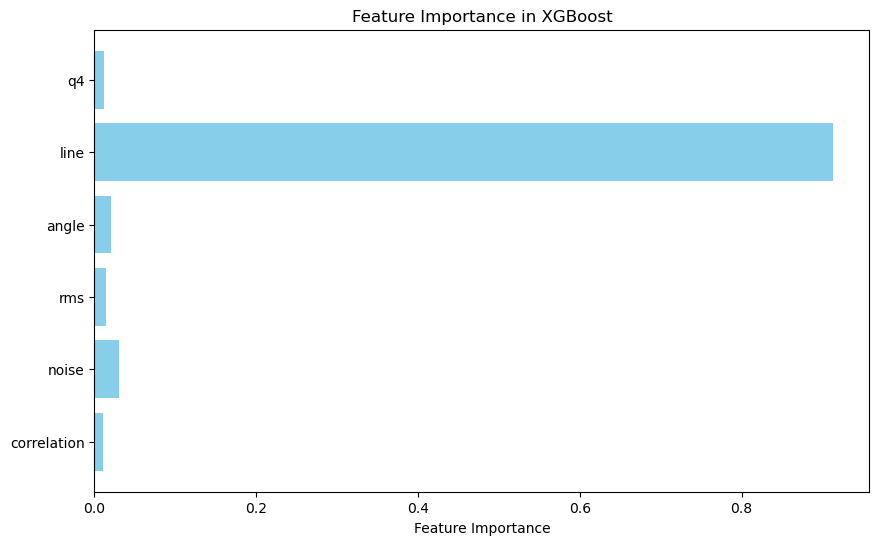

In [10]:
''' Using XG Boost '''
!pip install xgboost 

import xgboost as xgb
from sklearn.model_selection import train_test_split

# fit model to training data
model = xgb.XGBClassifier()
model.fit(x_train, y_train)


# Make predictions on the test set
y_pred3 = model.predict(x_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred3)
print(f"Accuracy: {accuracy * 100:.2f}%")

importances = model.feature_importances_

# Plotting the feature importances
feature_names = ['correlation', 'noise', 'rms', 'angle', 'line', 'q4']

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in XGBoost')
plt.show()

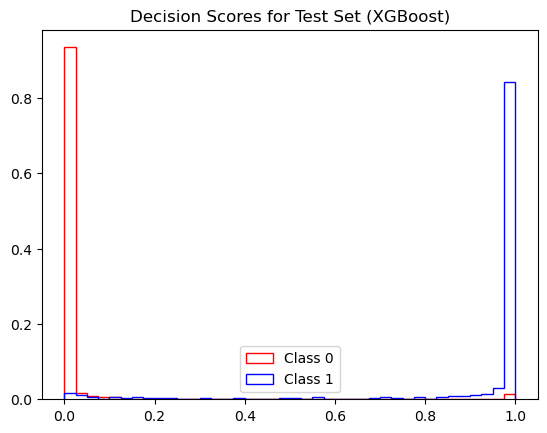

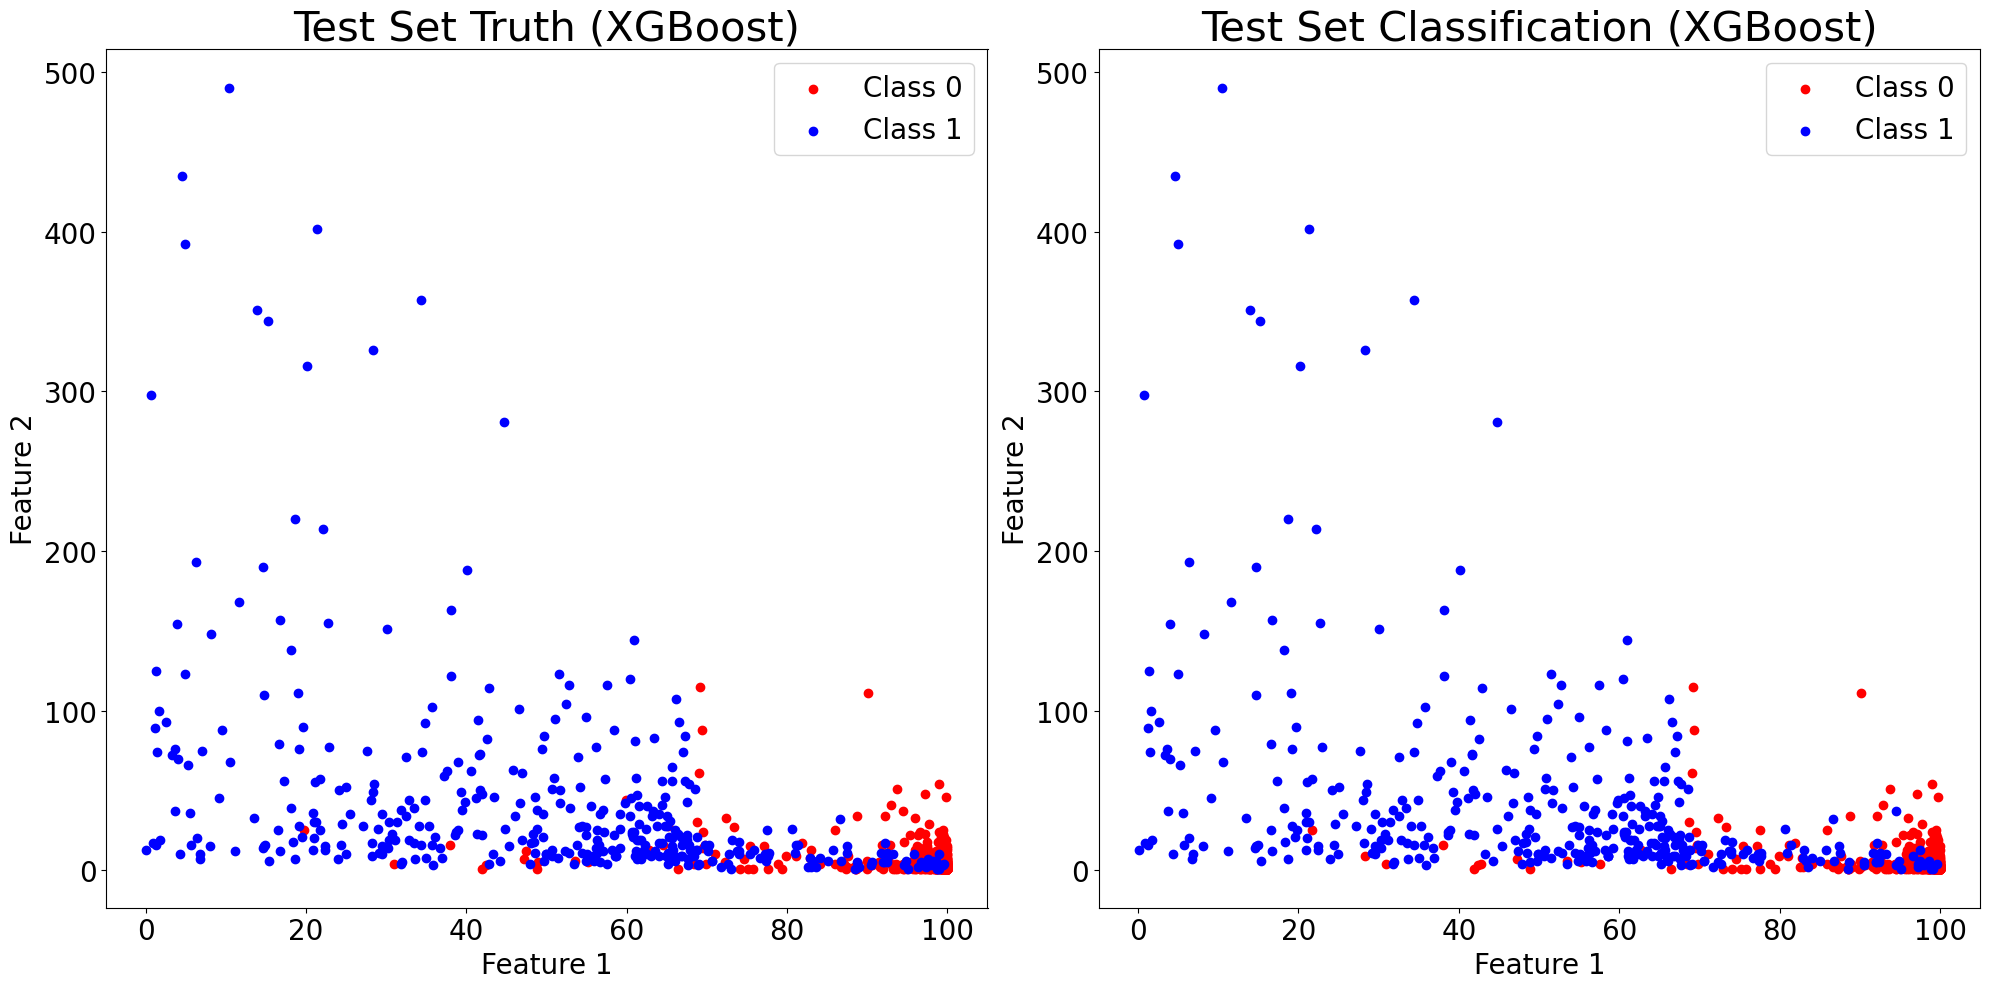

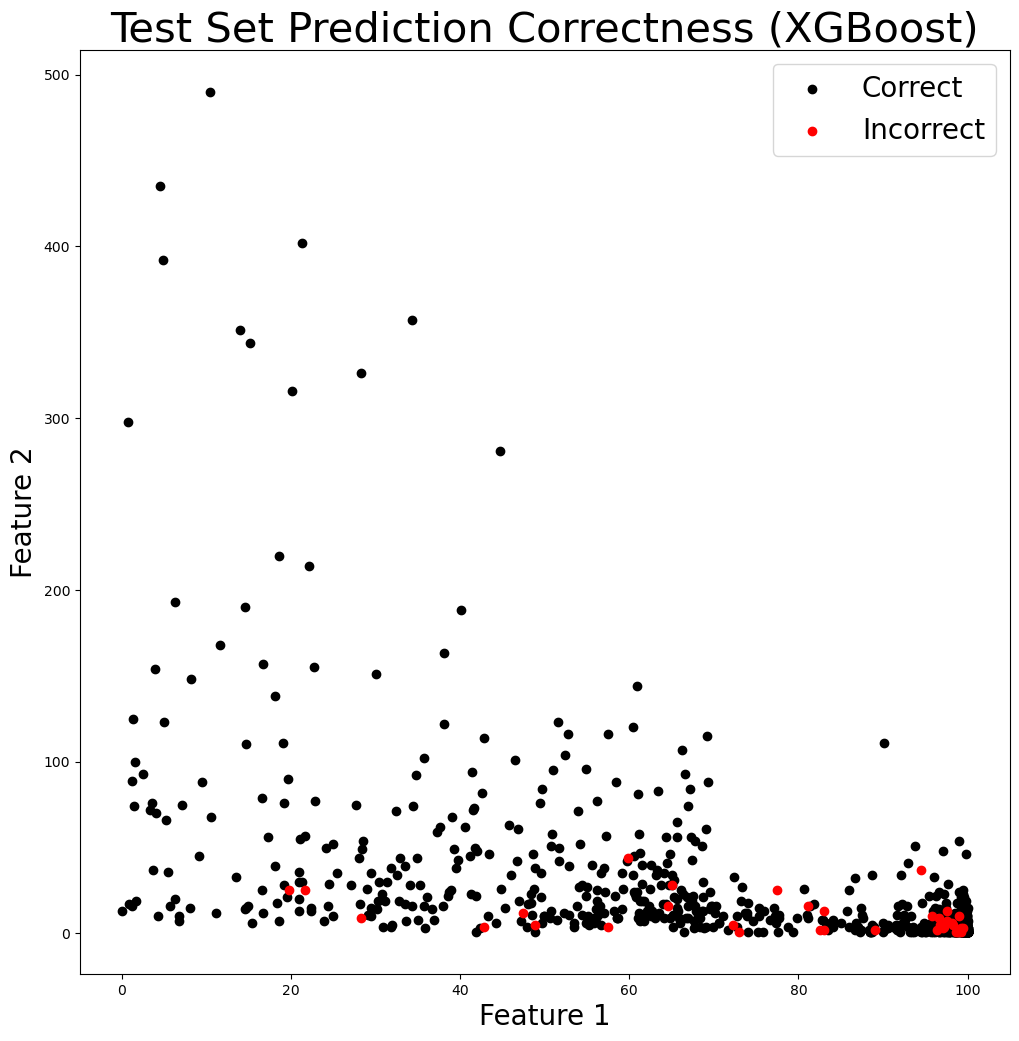

In [11]:
# Predict probabilities on the test set
test_scores = model.predict_proba(x_test)[:, 1]  # Get probability for class 1

# Plot Decision Scores (Histograms)
min_f = np.round(np.min(test_scores), 1)
max_f = np.round(np.max(test_scores), 1)
bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)

cls_0_scores = test_scores[np.where(y_test == 0)]
cls_1_scores = test_scores[np.where(y_test == 1)]

weights_0 = np.ones_like(cls_0_scores) / len(cls_0_scores)
weights_1 = np.ones_like(cls_1_scores) / len(cls_1_scores)

plt.hist(cls_0_scores, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0')
plt.hist(cls_1_scores, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1')
plt.legend()
plt.title("Decision Scores for Test Set (XGBoost)")
plt.show()

# Visualize classification on the test set (Ground truth vs Prediction)
titlesize = 30
labelsize = 20
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Ground truth
ax = axes[0]
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
cls_0 = np.where(y_test == 0)
ax.scatter(x_test[cls_0, 0], x_test[cls_0, 1], c="r", label="Class 0")
cls_1 = np.where(y_test == 1)
ax.scatter(x_test[cls_1, 0], x_test[cls_1, 1], c="b", label="Class 1")
ax.set_xlabel("Feature 1", fontsize=labelsize)
ax.set_ylabel("Feature 2", fontsize=labelsize)
ax.set_title("Test Set Truth (XGBoost)", fontsize=titlesize)
ax.legend(fontsize=labelsize)

# Predictions
ax = axes[1]
pred = model.predict(x_test)  # Get predictions
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
cls_0 = np.where(pred == 0)
ax.scatter(x_test[cls_0, 0], x_test[cls_0, 1], c="r", label="Class 0")
cls_1 = np.where(pred == 1)
ax.scatter(x_test[cls_1, 0], x_test[cls_1, 1], c="b", label="Class 1")
ax.set_xlabel("Feature 1", fontsize=labelsize)
ax.set_ylabel("Feature 2", fontsize=labelsize)
ax.set_title("Test Set Classification (XGBoost)", fontsize=titlesize)
ax.legend(fontsize=labelsize)

fig.tight_layout()
plt.show()

# Visualize prediction correctness
plt.figure(figsize=(12, 12))
correct = np.where(pred == y_test)
plt.scatter(x_test[correct, 0], x_test[correct, 1], c="k", label="Correct")
incorrect = np.where(pred != y_test)
plt.scatter(x_test[incorrect, 0], x_test[incorrect, 1], c="r", label="Incorrect")
plt.xlabel("Feature 1", fontsize=labelsize)
plt.ylabel("Feature 2", fontsize=labelsize)
plt.title("Test Set Prediction Correctness (XGBoost)", fontsize=titlesize)
plt.legend(fontsize=labelsize)
plt.show()

Text(0, 0.5, 'y_pred')

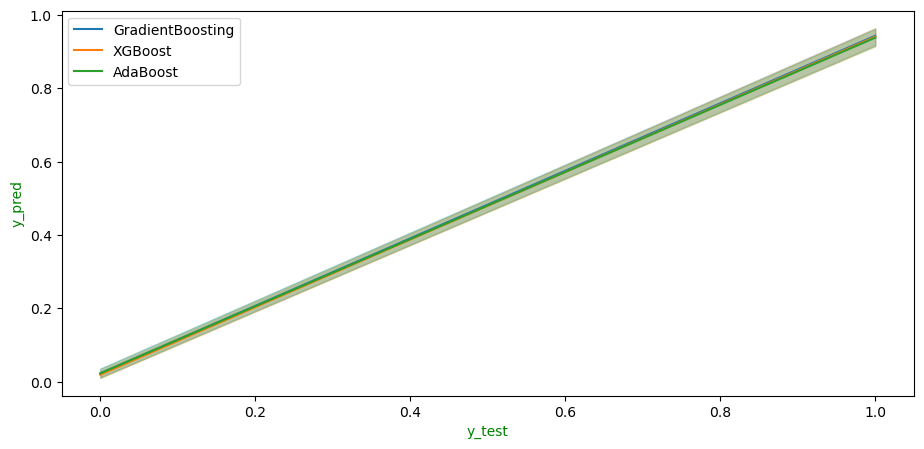

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(11, 5))
 
ax = sns.lineplot(x=y_test, y=y_pred,
                  label='GradientBoosting')
ax1 = sns.lineplot(x=y_test, y=y_pred2,
                   label='XGBoost')
ax2 = sns.lineplot(x=y_test, y=y_pred3,
                   label='AdaBoost')

 
ax.set_xlabel('y_test', color='g')
ax.set_ylabel('y_pred', color='g')